In [1]:
#Importing the Libraries
from os import minor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import math

In [2]:
# Getting the data sets
apple_df = pd.read_csv('../CSV/AAPL.csv', na_values=['null'], index_col='Date', parse_dates=True,infer_datetime_format=True)
microsoft_df = pd.read_csv('../CSV/MSFT_kaggle.csv', na_values=['null'], index_col='Date', parse_dates=True,infer_datetime_format=True)

df = pd.read_csv('../CSV/AAPL.csv', na_values=['null'], index_col='Date', parse_dates=True,infer_datetime_format=True)

Apple                 Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100600  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095352  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088353  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090540   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093165   73449600 
<<shape>> (10272, 6) 

Microsoft                 Open      High       Low     Close  Adj Close      Volume
Date                                                                     
1986-03-13  0.088542  0.101563  0.088542  0.097222   0.061434  1031788800
1986-03-14  0.097222  0.102431  0.097222  0.100694   0.063628   308160000
1986-03-17  0.100694  0.103299  0.100694  0.102431   0.064725   133171200
1986-03-18  0.102431  0.103299  0.098958  0.099826   0.063079    67766400
1986-

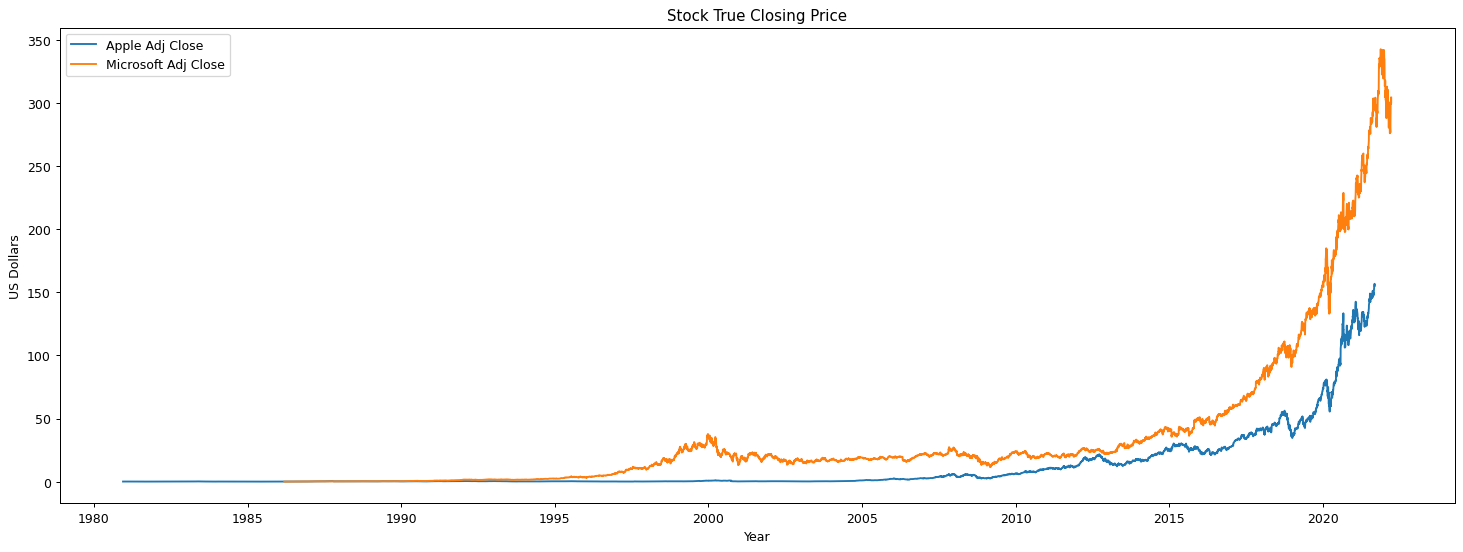

In [3]:
# Visual Analysis of the data (does it make sense)

#showing what the data looks like
print('Apple', apple_df.head(), '\n<<shape>>', apple_df.shape, '\n')
print('Microsoft', microsoft_df.head(), '\n<<shape>>', microsoft_df.shape)

# Ploting the data for visual analysis
plt.figure(figsize=(20,7), dpi=90)
# plt.grid(True)
plt.plot(apple_df['Adj Close'], label='Apple Adj Close')
plt.plot(microsoft_df['Adj Close'], label='Microsoft Adj Close')
plt.xlabel('Year')
plt.ylabel('US Dollars')
plt.title("Stock True Closing Price")
plt.legend()



In [4]:
#Set Target Variable
output_var = pd.DataFrame(df['Adj Close'])
apple_output_var = pd.DataFrame(apple_df['Adj Close'])
microsoft_output_var = pd.DataFrame(microsoft_df['Adj Close'])


#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']


#Scaling
scaler = MinMaxScaler(feature_range=(0,1))

feature_transform = scaler.fit_transform(df[features])
apple_feature_transform = scaler.fit_transform(apple_df[features])
microsoft_feature_transform = scaler.fit_transform(microsoft_df[features])

feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)

apple_feature_transform = pd.DataFrame(columns=features, data=apple_feature_transform, index=apple_df.index)
microsoft_feature_transform = pd.DataFrame(columns=features, data=microsoft_feature_transform, index=microsoft_df.index)


Apple                 Open      High       Low    Volume
Date                                              
1980-12-12  0.000501  0.000504  0.000513  0.063198
1980-12-15  0.000462  0.000461  0.000470  0.023699
1980-12-16  0.000405  0.000405  0.000412  0.014246
1980-12-17  0.000420  0.000422  0.000430  0.011647
1980-12-18  0.000441  0.000444  0.000452  0.009897 
<<shape>> (10272, 4) 

Microsoft                 Open      High       Low    Volume
Date                                              
1986-03-13  0.000000  0.000027  0.000000  1.000000
1986-03-14  0.000025  0.000030  0.000025  0.297096
1986-03-17  0.000035  0.000032  0.000036  0.127119
1986-03-18  0.000040  0.000032  0.000030  0.063588
1986-03-19  0.000033  0.000025  0.000025  0.044285 
<<shape>> (9083, 4)


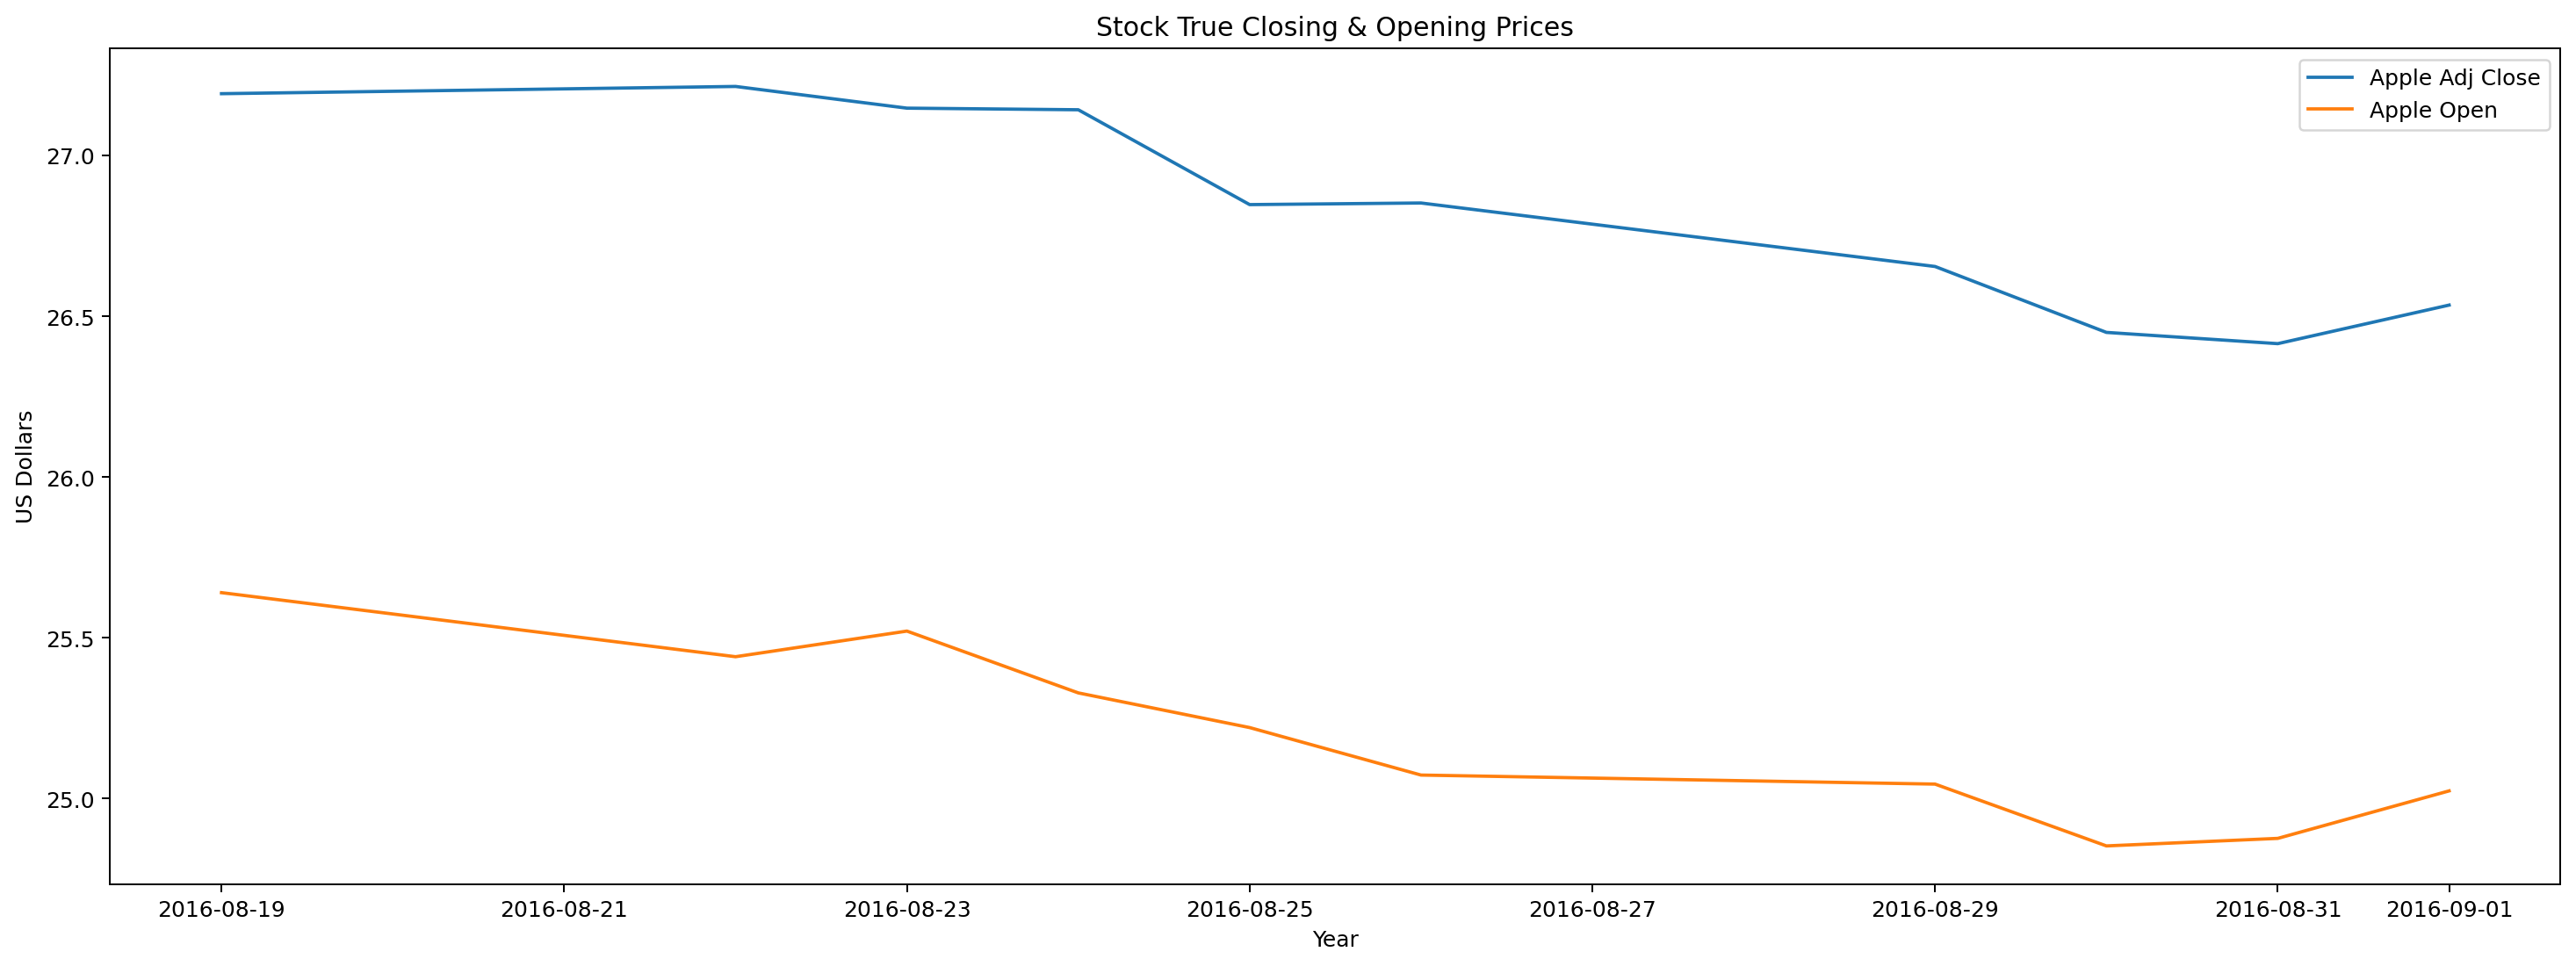

In [5]:
#Visualizing Transformed Data
print('Apple', apple_feature_transform.head(), '\n<<shape>>', apple_feature_transform.shape, '\n')
print("Microsoft", microsoft_feature_transform.head(), '\n<<shape>>', microsoft_feature_transform.shape)

# note, in many cases, today's adj close (what we are trying to predict) is tomorrow's open. 
# Our model may pick up on this fact, resulting in the prediction lagging one day behind
# Here is a plot looking at the ADJ Close and the Open For APPLE, the open should look like ADJ close, just one day behind

# start = 0
# end = len(apple_df)
start = 9000
end = 9010
plt.figure(figsize=(20,7), dpi=180)
plt.plot(apple_df['Open'][start:end], label='Apple Adj Close')
plt.plot(apple_df['Adj Close'][start:end], label='Apple Open')
plt.xlabel('Year')
plt.ylabel('US Dollars')
plt.title("Stock True Closing & Opening Prices")
plt.legend()

In [6]:
#splitting to Training set and Test Set
timesplit = TimeSeriesSplit(n_splits=10)

# Using the Microsoft Data
for train_index, test_index in timesplit.split(microsoft_feature_transform):
  X_train, X_test = microsoft_feature_transform[:len(train_index)], microsoft_feature_transform[len(train_index): ]
  y_train, y_test = microsoft_output_var[:len(train_index)].values.ravel(), microsoft_output_var[len(train_index): (len(train_index) + len(test_index))].values.ravel()

# #using the Apple Data 
# for train_index, test_index in timesplit.split(apple_feature_transform):
#   X_train, X_test = apple_feature_transform[:len(train_index)], apple_feature_transform[len(train_index): ]
#   y_train, y_test = apple_output_var[:len(train_index)].values.ravel(), apple_output_var[len(train_index): (len(train_index) + len(test_index))].values.ravel()


#Pre-process the data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [7]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation="elu", return_sequences=False))
lstm.add(Dense(32, activation='elu'))
lstm.add(Dense(15, activation='elu'))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
# plot_model(lstm, show_shapes=True, show_layer_names=True)

2022-05-15 08:21:22.937334: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#early stopping
earlyStop = EarlyStopping(
  monitor='loss',
  min_delta=0.01,
  patience=10,
  mode='min',
  verbose=1,
  restore_best_weights=True
)

In [9]:
#Model Training
history=lstm.fit(X_train, y_train, epochs=300, batch_size=8, verbose=1, shuffle=False, callbacks=[earlyStop])

Epoch 1/300
1033/1033 [==============================] - 2s 1ms/step - loss: 3.8055
Epoch 2/300
1033/1033 [==============================] - 1s 1ms/step - loss: 49.0468
Epoch 3/300
1033/1033 [==============================] - 1s 1ms/step - loss: 18.2765
Epoch 4/300
1033/1033 [==============================] - 1s 1ms/step - loss: 2.9391
Epoch 5/300
1033/1033 [==============================] - 1s 1ms/step - loss: 0.4615
Epoch 6/300
1033/1033 [==============================] - 1s 1ms/step - loss: 0.4419
Epoch 7/300
1033/1033 [==============================] - 1s 1ms/step - loss: 0.4484
Epoch 8/300
1033/1033 [==============================] - 1s 1ms/step - loss: 0.3876
Epoch 9/300
1033/1033 [==============================] - 1s 1ms/step - loss: 0.3424
Epoch 10/300
1033/1033 [==============================] - 1s 1ms/step - loss: 0.3305
Epoch 11/300
1033/1033 [==============================] - 1s 1ms/step - loss: 0.3311
Epoch 12/300
1033/1033 [==============================] - 1s 1ms/step - 

In [10]:
#LSTM Prediction
y_pred = lstm.predict(X_test)

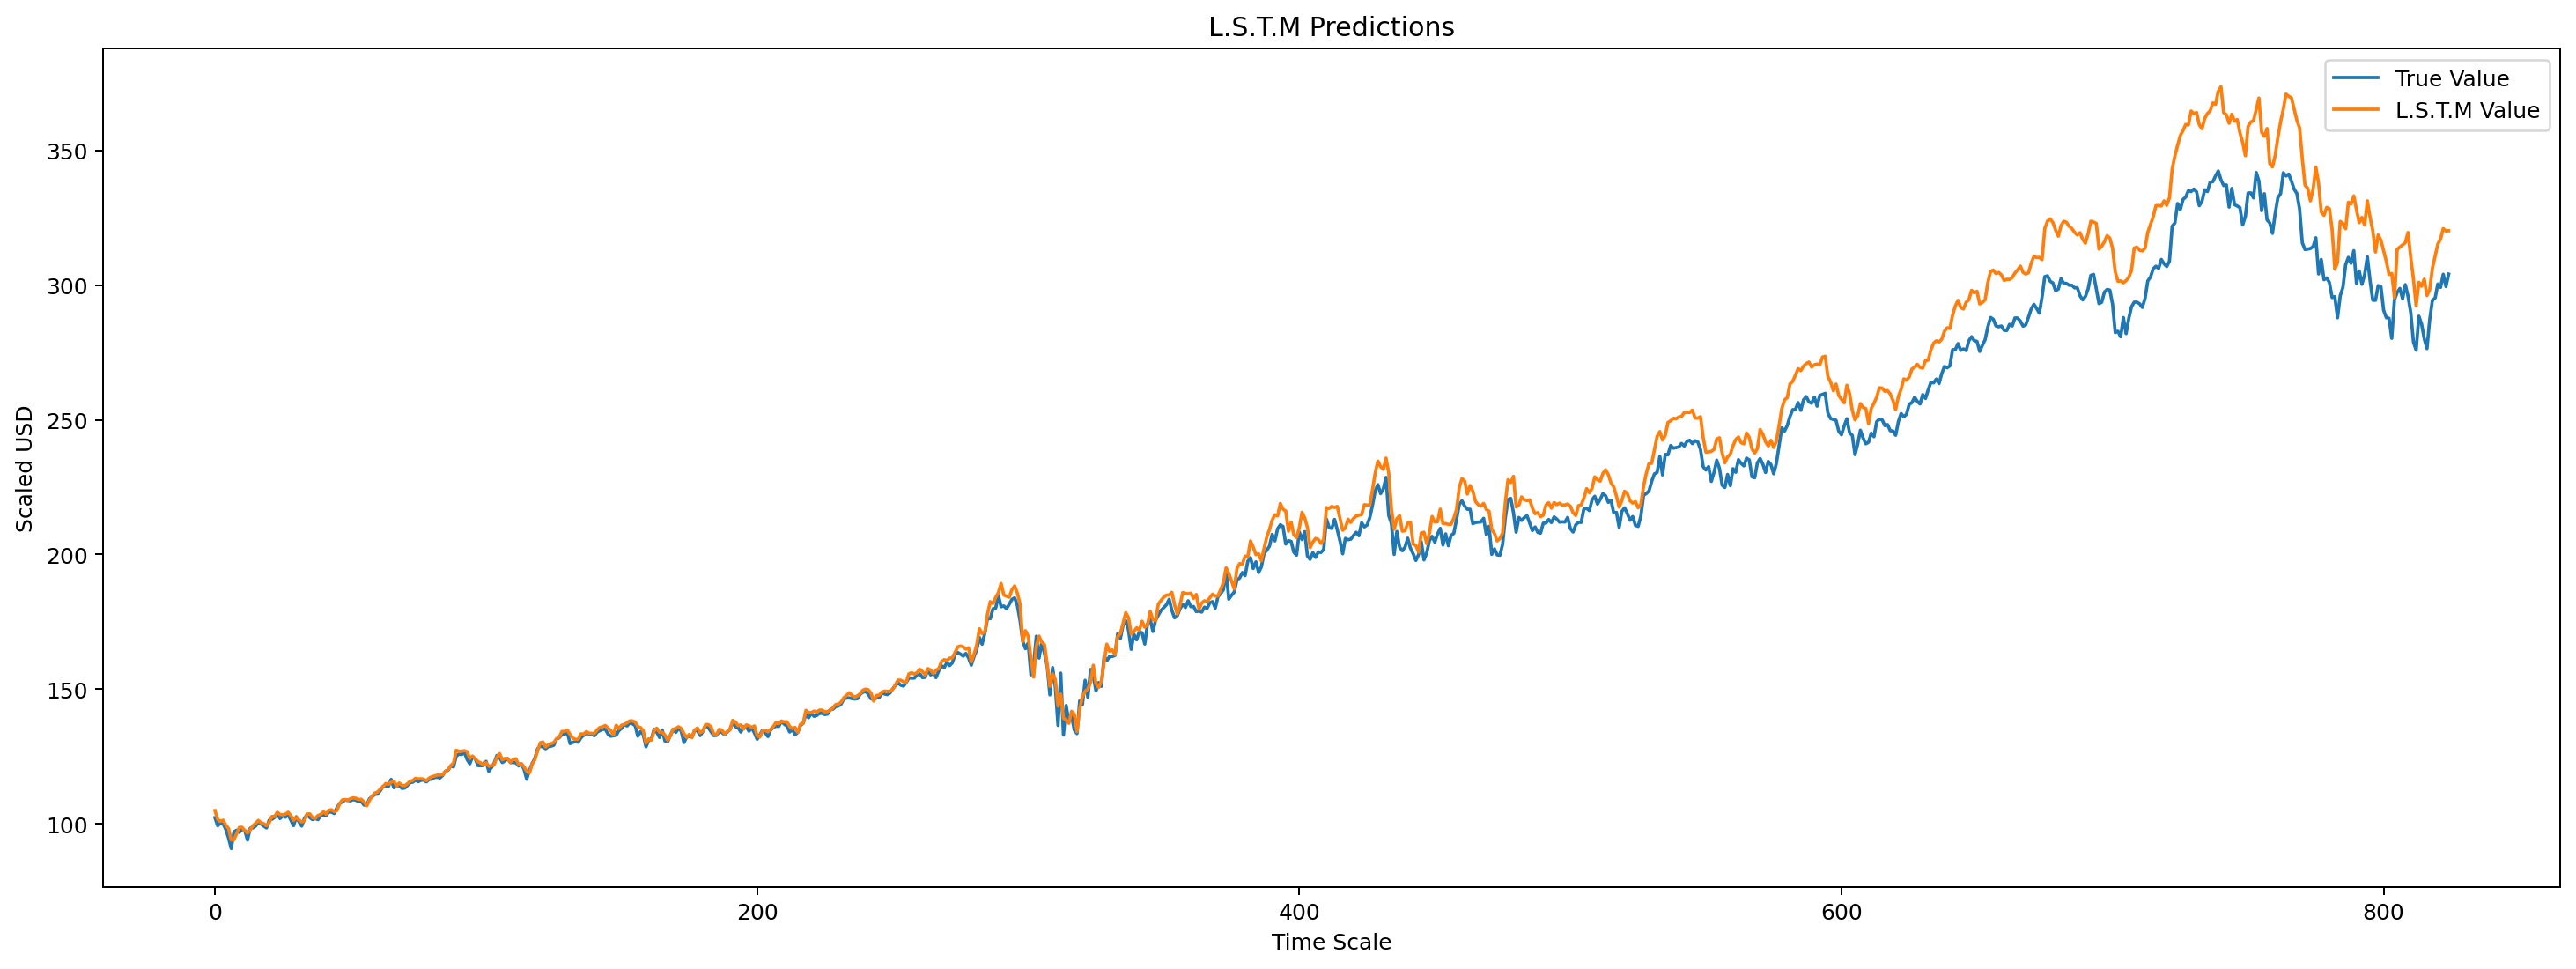

In [11]:
#Showing the results
# start = 275
# end = 400
start = 0
end = len(y_pred)

plt.figure(figsize=(20,7), dpi=180)
plt.plot(y_test[start:end], label='True Value')
plt.plot(y_pred[start:end], label='L.S.T.M Value')
plt.title("L.S.T.M Predictions")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()

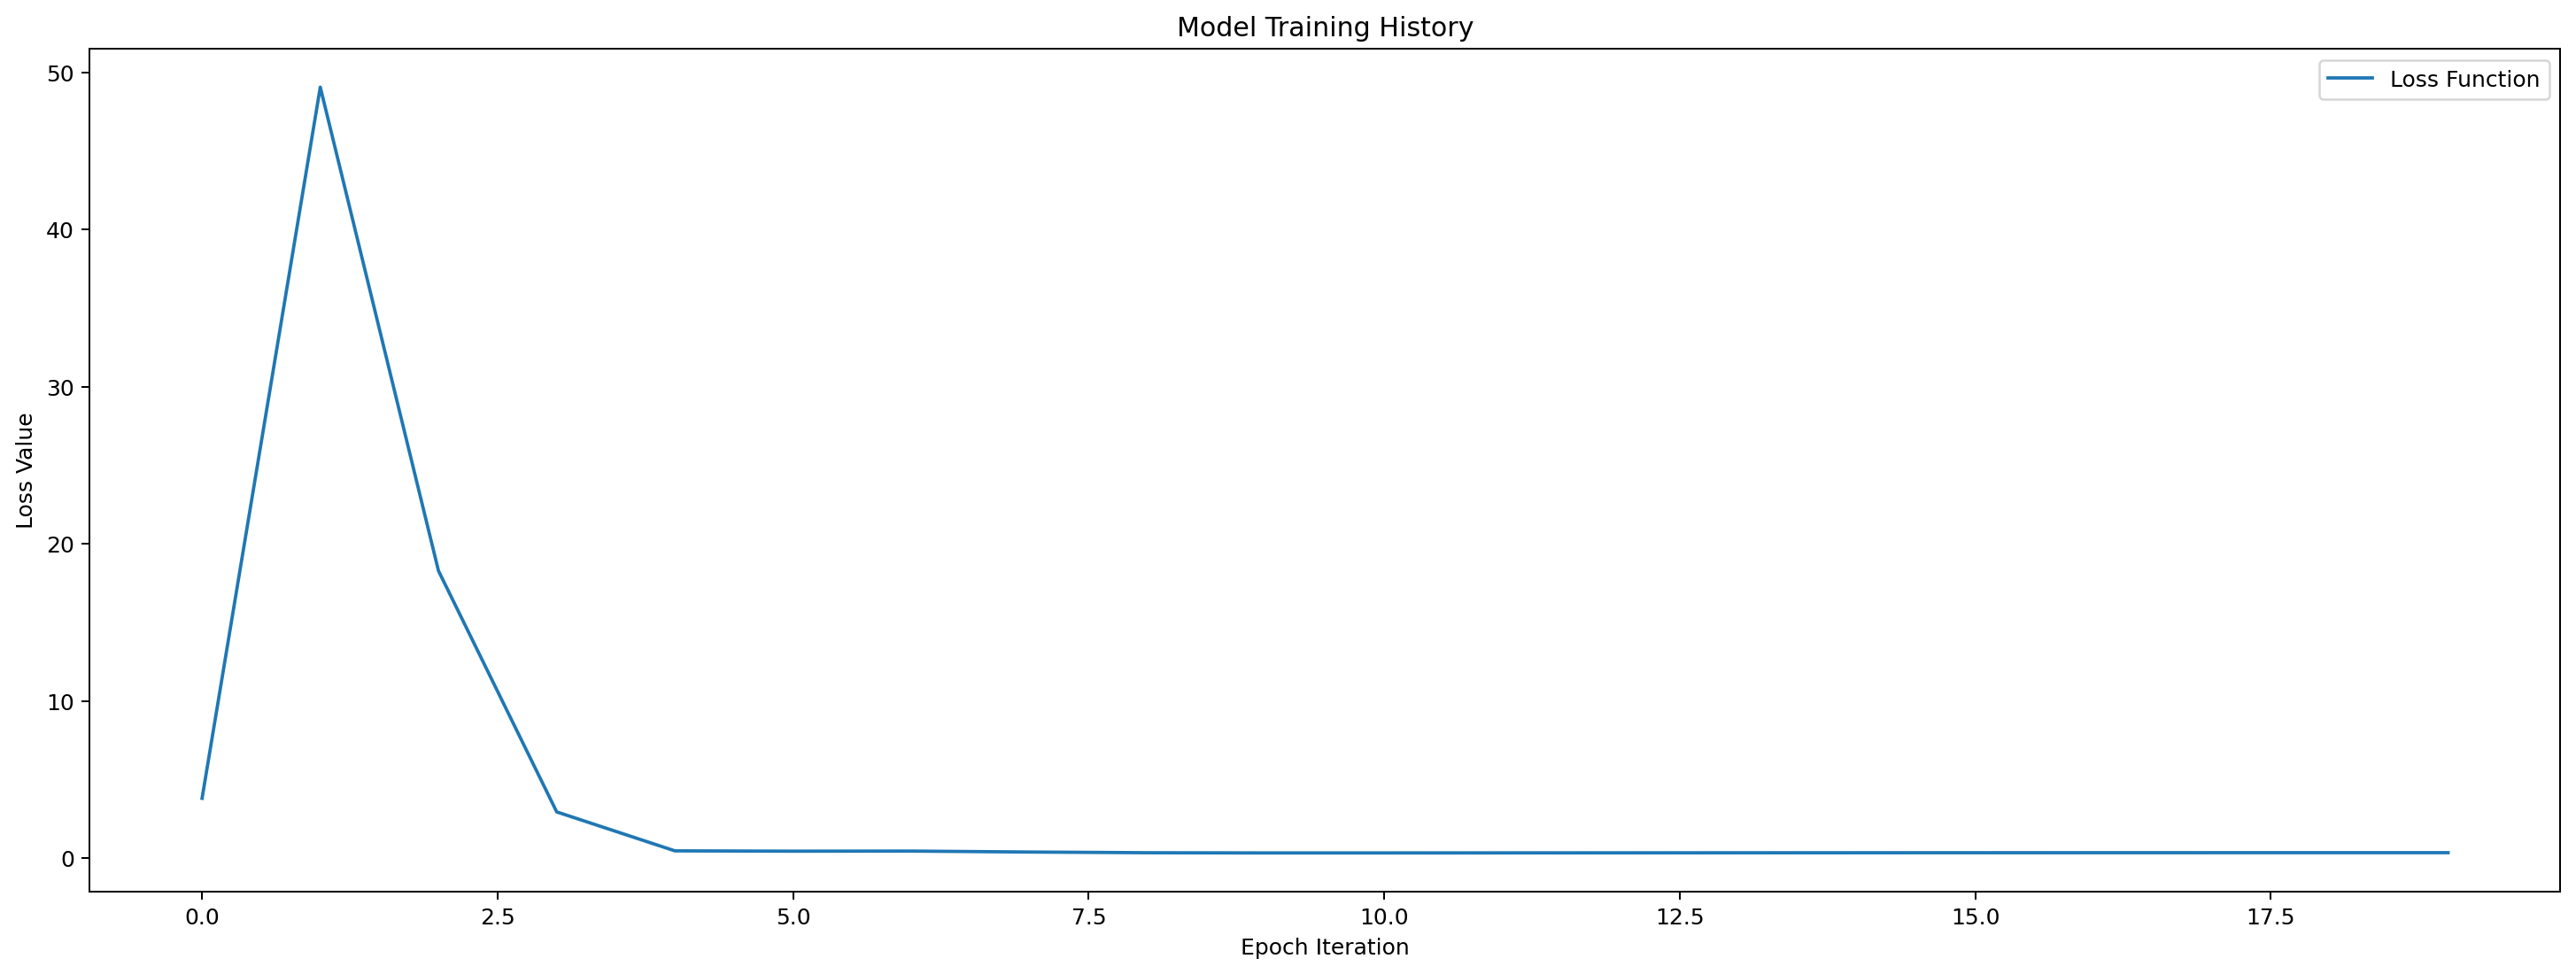

In [12]:
#Showing Model history 
plt.figure(figsize=(20,7), dpi=180)
plt.plot(pd.DataFrame(history.history), label='Loss Function')
plt.xlabel('Epoch Iteration')
plt.ylabel("Loss Value")
plt.title("Model Training History")
plt.legend()